<a href="https://colab.research.google.com/github/ssaran2014/tensorflow/blob/master/binary_alpha_digits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Binary_Alpha_Digits**

This code is to practice image classification using tensorflow with a fairly simple and small dataset.

The dataset is here: https://www.tensorflow.org/datasets/catalog/binary_alpha_digits


In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [2]:
#An overview of loading the dataset is here: https://www.tensorflow.org/datasets/overview

ds, info = tfds.load('binary_alpha_digits', 
                     split='train', 
                     as_supervised=True, #downloaded along with the labels
                     #batch_size=-1, #downloaded as one batch 
                     shuffle_files=True, 
                     with_info = True)


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/binary_alpha_digits/1.0.0.incompleteUK1JYE/binary_alpha_digits-train.tfrecord


Dataset binary_alpha_digits downloaded and prepared to /root/tensorflow_datasets/binary_alpha_digits/1.0.0. Subsequent calls will reuse this data.


In [5]:
print(info)

tfds.core.DatasetInfo(
    name='binary_alpha_digits',
    version=1.0.0,
    description='Binary 20x16 digits of '0' through '9' and capital 'A' through 'Z'. 39 examples of each class.',
    homepage='https://cs.nyu.edu/~roweis/data/',
    features=FeaturesDict({
        'image': Image(shape=(20, 16, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=36),
    }),
    total_num_examples=1404,
    splits={
        'train': 1404,
    },
    supervised_keys=('image', 'label'),
    citation="""""",
    redistribution_info=,
)



Note that the dataset is quite small. There are just 39 examples of each class. There are 36 classes.

In [6]:
#print number of classes
print('Number of classes: {}'.format(info.features["label"].num_classes))

#print labels
print('\nLabels:')
print(info.features["label"].names)
labels = info.features["label"].names

#print shape of each image
print('\nShape of each image: ' + str(info.features['image'].shape))

Number of classes: 36

Labels:
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

Shape of each image: (20, 16, 1)


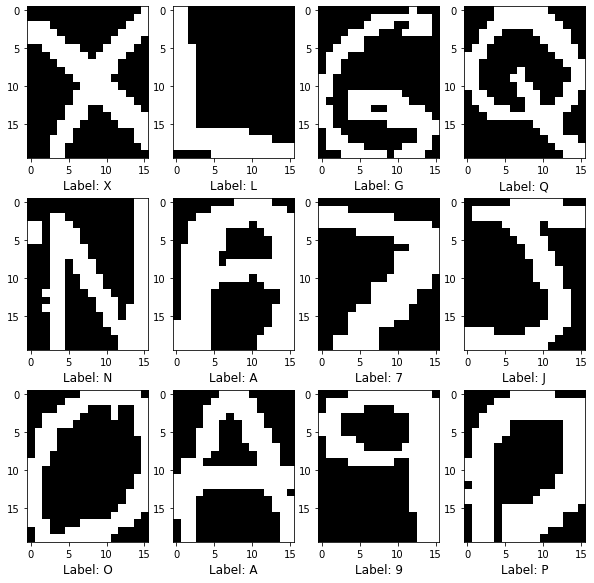

In [7]:
#visualize the first few images
ds_example = ds.take(12)
fig = plt.figure(figsize=(10,10))

counter = 1
for sample in ds_example:
    image, label = sample[0].numpy(), 'Label: '+str(labels[(sample[1].numpy())])
    plt.subplot(3, 4, counter)
    plt.imshow(image[:, :, 0].astype(np.uint8), cmap=plt.get_cmap("gray"))
    plt.xlabel(label, fontsize=12)
    counter += 1
plt.show()

In [9]:
percentage_as_train = 0.8
train_size = round(percentage_as_train * info.splits['train'].num_examples) #20% of the data is test
print('Total number of images: ', info.splits['train'].num_examples)
print('Percentage taking for training: ', percentage_as_train)
print('Training size: ', train_size)

Total number of images:  1404
Percentage taking for training:  0.8
Training size:  1123


In [10]:
ds.shuffle(buffer_size=2000) #shuffling the data before creating a training and test set
train_ds = ds.take(train_size)
test_ds = ds.skip(train_size)

In [11]:
#build the training pipeline
#broadly uses the guideline provided here https://www.tensorflow.org/datasets/keras_example
#because of the similarity of the datasets

def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  image = tf.cast(image, tf.float32) / 255.
  return image, label

train_ds = train_ds.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_ds = train_ds.cache()
train_ds = train_ds.shuffle(train_size)
train_ds = train_ds.batch(128)
train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE)

In [12]:
#build the evaluation pipeline

test_ds = test_ds.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.batch(128)
test_ds = test_ds.cache()
test_ds = test_ds.prefetch(tf.data.experimental.AUTOTUNE)

In [20]:
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv2D(32, (3,3), input_shape=(20,16,1), activation = 'relu'),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(64, activation = 'relu'),
                                    tf.keras.layers.Dense(36, activation = 'softmax')
                              ])

"""
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv2D(32, (3,3), input_shape=(20,16,1), activation = 'relu'),
                                    tf.keras.layers.MaxPool2D(2,2),
                                    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'),
                                    tf.keras.layers.MaxPool2D(2,2),
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(512, activation = 'relu'),
                                    tf.keras.layers.Dense(128, activation = 'relu'),
                                    tf.keras.layers.Dense(36, activation = 'softmax')
                              ])
"""

model.summary()

model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(lr=1e-3),
    metrics = ['accuracy']
)

history = model.fit(
    train_ds,
    batch_size = 256,
    epochs = 150,
    validation_data = test_ds,
    verbose = 1
)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 18, 14, 32)        320       
_________________________________________________________________
flatten_4 (Flatten)          (None, 8064)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                516160    
_________________________________________________________________
dense_9 (Dense)              (None, 36)                2340      
Total params: 518,820
Trainable params: 518,820
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
9/9 [==============================] - 0s 46ms/step - loss: 3.5836 - accuracy: 0.0214 - val_loss: 3.5836 - val_accuracy: 0.0320
Epoch 2/150
9/9 [==============================] - 0s 38ms/step - loss: 3.5818 - accuracy: 0.0276 - val_lo

Text(0.5, 1.0, 'Training and Validation Loss')

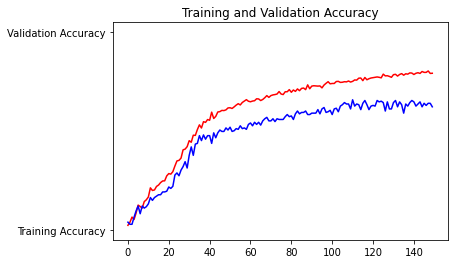

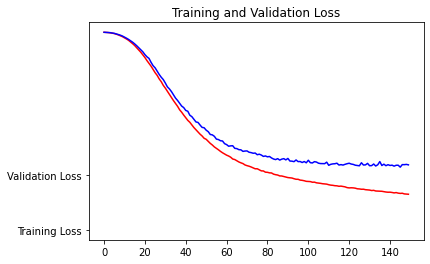

In [19]:
#plotting the loss function and accuracy

#retrieving a list of list results on training and validation datasets for each epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc)) #get number of epochs

#plot training and validation accuracy per epoch
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.figure()

#plot training and validation loss per epoch
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.title("Training and Validation Loss")

In [ ]:
#without convolution layer and 100 epochs
#9/9 [==============================] - 0s 16ms/step - loss: 2.0674 - accuracy: 0.5886 - val_loss: 2.2043 - val_accuracy: 0.4769
#losses are still decreasing with each epoch

# with 500 epochs
#9/9 [==============================] - 0s 15ms/step - loss: 0.6214 - accuracy: 0.8353 - val_loss: 0.9954 - val_accuracy: 0.6370
#losses flat. Model has stopped improving. Peak accuracy around 64%. Not great.

#Epoch 100/100. with one convolution layer of 16
#9/9 [==============================] - 0s 27ms/step - loss: 1.0626 - accuracy: 0.6955 - val_loss: 1.3449 - val_accuracy: 0.5836

#epochs = 500. Convolution layer of 16.
#9/9 [==============================] - 0s 29ms/step - loss: 0.3176 - accuracy: 0.9047 - val_loss: 1.3683 - val_accuracy: 0.6406
# No improvement in accuracy after 200 epochs

#epochs = 250, conv2D layer 16, batch_size = 32
#9/9 [==============================] - 0s 27ms/step - loss: 0.7694 - accuracy: 0.7676 - val_loss: 1.2143 - val_accuracy: 0.6014

#epochs = 350, 1 conv layer 16, batch_size = 64
#9/9 [==============================] - 0s 28ms/step - loss: 0.5824 - accuracy: 0.8237 - val_loss: 1.1327 - val_accuracy: 0.6548

#epochs = 350, 2 conv layer 16 and 32, batch_size = 64
#9/9 [==============================] - 0s 33ms/step - loss: 0.8611 - accuracy: 0.7311 - val_loss: 1.6039 - val_accuracy: 0.5552
#With 2 conv layers accuracy goes down!

#epochs = 350, 2 conv layer 32 and 64, dense layer = 64, no batch size specified
#9/9 [==============================] - 0s 45ms/step - loss: 0.6981 - accuracy: 0.7854 - val_loss: 1.5553 - val_accuracy: 0.5836

##epochs = 350, 2 conv layer 32 and 64, dense layer = 128, no batch size specified
#9/9 [==============================] - 0s 46ms/step - loss: 0.5634 - accuracy: 0.8335 - val_loss: 1.5890 - val_accuracy: 0.5836

##epochs = 350, 2 conv layer 32 and 64, dense layer = 128, no batch size specified; added Dropout 0.5
#9/9 [==============================] - 0s 49ms/step - loss: 0.8664 - accuracy: 0.6990 - val_loss: 1.3230 - val_accuracy: 0.5801
#no benefit of adding dropout

##epochs = 350, 2 conv layer 32 and 64, dense layer = 512, no batch size specified; added Dropout 0.5
#9/9 [==============================] - 0s 48ms/step - loss: 0.3319 - accuracy: 0.8851 - val_loss: 1.5001 - val_accuracy: 0.6157
#significant overfitting. 

##epochs = 350, 2 conv layer 32 and 64, dense layer = 128, batch size=128 specified; added Dropout 0.5
#9/9 [==============================] - 0s 48ms/step - loss: 0.7529 - accuracy: 0.7435 - val_loss: 1.2398 - val_accuracy: 0.6335

##epochs = 350, 2 conv layer 32 and 64, dense layer = 128, batch size=128 specified; added Dropout 0.5; learning_rate = 1e-4
#9/9 [==============================] - 0s 45ms/step - loss: 1.5120 - accuracy: 0.5441 - val_loss: 1.7007 - val_accuracy: 0.4698
#rate of learning is very slow. Model is improving.

##epochs = 350, 2 conv layer 32 and 64, dense layer = 128, batch size=256 specified; added Dropout 0.5; learning_rate = 1e-3
#9/9 [==============================] - 0s 45ms/step - loss: 0.7358 - accuracy: 0.7373 - val_loss: 1.2590 - val_accuracy: 0.6228

##epochs = 350, 2 conv layer 32 and 64, dense layer = 512, 128, batch size=256 specified; added Dropout 0.5; learning_rate = 1e-3
#9/9 [==============================] - 0s 49ms/step - loss: 0.5536 - accuracy: 0.7996 - val_loss: 1.3548 - val_accuracy: 0.6014
#overfitting

#Epoch =150, conv layer 32, dense layer 64, batch size = 256, learning_rate = 1e-3
#9/9 [==============================] - 0s 34ms/step - loss: 0.6029 - accuracy: 0.8210 - val_loss: 1.1591 - val_accuracy: 0.6406

#Epoch 150/150
#9/9 [==============================] - 0s 36ms/step - loss: 0.7021 - accuracy: 0.7854 - val_loss: 1.1808 - val_accuracy: 0.6299

**Conclusions**

1. A simple model with three layers works just as well as a model with 2 conv layers, and three dense layers.

2. Adam optimizer and RMSProp optimizers work equally well.

3. With Adam optmizer, reducing learning rate from 1e-3 to 1e-4 doesn't show any improvement.

4. Overfitting starts occuring at 62-64% accuracy on the validation set. Increasing the size of the training data might lead to higher accuracy.

5. Image augmentation was not performed as it was not clear which augmentations would be suitable for this type of dataset.